In [1]:
from rotation_reconstruction import *

In [18]:
pars = camb.CAMBparams()
pars.set_cosmology(H0=67.4, ombh2=0.0224, omch2=0.12, mnu=0.06, omk=0, tau=0.054)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(30000, lens_potential_accuracy=2) # lens_potential_accuracy=1 is Planck accuracy. See doc
results = camb.get_results(pars)
# get dictionary of CAMB power spectra, 'unlensed_scalar' is ordered TT, EE, BB, TE, with BB = 0
# 'lens_potential' is orderd psi_psi, T_psi, E_psi
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True) # raw_cl so that no factors of ell are multiplied to C_ell
# for name in powers: print(name)

# Basics

In [3]:
# eps matrix for cross product or calculation of sine
us = np.random.random((10,2))
vs = np.random.random((10,2))
useps = us@eps

cross1 = np.array([useps[i]@vs[i] for i in range(len(us))]) # use us@eps as the first factor in a dot product
cross2 = np.cross(-us, vs) # regular cross product
cross3 = np.array([np.linalg.norm(us[i])*np.linalg.norm(vs[i])*np.sin(np.angle(us[i,0]+1j*us[i,1])-np.angle(vs[i,0]+1j*vs[i,1])) for i in range(len(us))]) # explicitly compute sine

print(cross1)
print(cross2)
print(cross3)
# validate: cross1 == cross2, and cross3 ~ cross1

[ 0.18996978 -0.21941769 -0.48357393  0.13024534 -0.22590842  0.20526151
 -0.18520195  0.67347879  0.15306223  0.08025844]
[ 0.18996978 -0.21941769 -0.48357393  0.13024534 -0.22590842  0.20526151
 -0.18520195  0.67347879  0.15306223  0.08025844]
[ 0.18996978 -0.21941769 -0.48357393  0.13024534 -0.22590842  0.20526151
 -0.18520195  0.67347879  0.15306223  0.08025844]


In [6]:
# get_ls()
cmb = CMBGenerator(powers, 0.4, 9)
print(cmb.ls_grid[:,:,0]*cmb.W/(2*np.pi))
print(cmb.ls_grid[:,:,1]*cmb.W/(2*np.pi))
# validate: first coordinate is (downwards) 0 -- positive modes -- (negative nyquist) -- negative modes
# second coordinate is (rightwards) 0 -- positive modes -- (positive nyquist)

[[ 0.  0.  0.  0.  0.]
 [ 1.  1.  1.  1.  1.]
 [ 2.  2.  2.  2.  2.]
 [ 3.  3.  3.  3.  3.]
 [ 4.  4.  4.  4.  4.]
 [-4. -4. -4. -4. -4.]
 [-3. -3. -3. -3. -3.]
 [-2. -2. -2. -2. -2.]
 [-1. -1. -1. -1. -1.]]
[[0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]
 [0. 1. 2. 3. 4.]]


In [5]:
# mirrorFourier()
cmb = CMBGenerator(powers, 0.4, 191)
cmb.setPrimordialMaps()

np.max(np.abs(np.fft.fft2(cmb.T_prim.real)-mirrorFourier(cmb.T_prim.fourier)))
# validate: number is really small

1.1641532182693481e-10

In [47]:
# mul()
a = np.random.random((6,4,2,3,4))
b = np.random.random((6,4,5,2))
c = mul(a, b)

c[3,2,0,1,2,4,1] - a[3,2,0,1,2]*b[3,2,4,1]
# validate: 0

0.0

In [48]:
# tensorProd()
first = np.random.random((5,4))
v1 = np.random.random((5, 4, 3))
v2 = np.random.random((5, 4, 2))
p = tensorProd(first, v1, v2)

p[2,3,2,0] - first[2,3]*v1[2,3,2]*v2[2,3,0]
# validate: 0

0j

In [18]:
# dotL()
cmb = CMBGenerator(powers, 0.4, 191)
to_dot = np.random.random((cmb.N,cmb.N//2+1,2,2,2,2,2))
dotted = cmb.dotL(to_dot)

ind = (100, 80)
L = cmb.ls_grid[ind]
dotted[ind] - to_dot[ind]@L@L@L@L@L
# validate: 0

0j

In [60]:
# expandProd()
factor1 = [(np.random.random((6,4,3,4)), np.random.random((6,4))), (np.random.random((6,4)), np.random.random((6,4,3,4)))]
factor2 = [(np.random.random((6,4)), np.random.random((6,4))), (np.random.random((6,4)), np.random.random((6,4,3)))]
factor3 = [(np.random.random((6,4)), np.random.random((6,4))), (np.random.random((6,4)), np.random.random((6,4,3)))]
prod = expandProd(factor1, factor2, factor3)

prod[7][1][:,:,2,2,2,2] - factor1[1][1][:,:,2,2] * factor2[1][1][:,:,2] * factor3[1][1][:,:,2]
# validate: all 0

array([[0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.],
       [0., 0., 0., 0.]])

# Generating maps by sampling

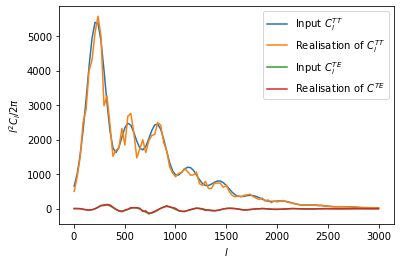

In [3]:
# sampleCov()
cmb = CMBGenerator(powers, 0.4, 151)
ls = np.linspace(2, 3000, 103) # test for non-integers too
samples = np.array([[cmb.sampleCov(l) for l in ls] for i in range(100)])
samples_sq = samples*np.conj(samples)
samples_sq_mean = np.real(np.mean(samples_sq, axis=0)) # imag part approaches zero for high sample number

plt.plot(ls, cmb.C_TT(ls) *ls**2/(2*np.pi), label='Input $C^{TT}_l$')
plt.plot(ls, samples_sq_mean[:,0]/cmb.N**4*cmb.W**2 *ls**2/(2*np.pi), label='Realisation of $C^{TT}_l$') # need to divide by N**4/W**2 to get power spectrum

plt.plot(ls, cmb.C_TE(ls) *ls**2/(2*np.pi), label='Input $C^{TE}_l$')
plt.plot(ls, np.real(np.mean(samples[:,:,0]*np.conj(samples[:,:,1]), axis=0))/cmb.N**4*cmb.W**2 *ls**2/(2*np.pi), label='Realisation of $C^{TE}$')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.legend()
plt.show()
# validate: the two pairs of curves (TT, TE) match

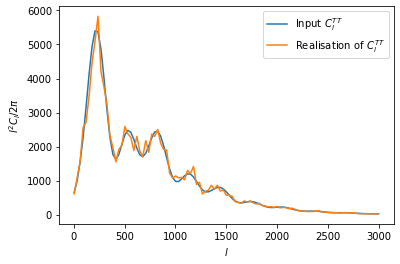

In [4]:
# sample()
cmb = CMBGenerator(powers, 0.4, 151)
ls = np.linspace(2, 3000, 103) # test for non-integers too
samples = np.array([[cmb.sample(cmb.C_TT, l) for l in ls] for i in range(100)])

plt.plot(ls, cmb.C_TT(ls) *ls**2/(2*np.pi), label='Input $C^{TT}_l$')
plt.plot(ls, np.real(np.mean(samples*np.conj(samples), axis=0))/cmb.N**4*cmb.W**2 *ls**2/(2*np.pi), label='Realisation of $C^{TT}_l$')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.legend()
plt.show()
# validate: two curves match

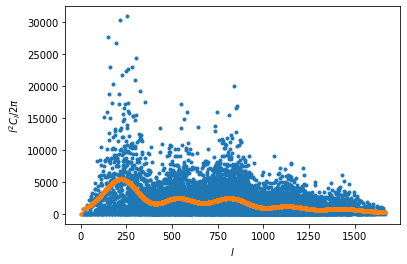

In [5]:
# setPrimordialMaps
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
ls = np.concatenate(cmb.norm_ls_grid)

plt.plot(ls, np.concatenate(np.real(cmb.T_prim.fourier*np.conj(cmb.T_prim.fourier)))/cmb.N**4*cmb.W**2 *ls**2/(2*np.pi), '.')
plt.plot(ls, cmb.C_TT(ls) *ls**2/(2*np.pi), '.')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.show()
# validate: blue dots more or less scatter around the orange curve

In [6]:
# temperature anisotropy
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()

np.sqrt(np.mean(cmb.T_prim.real**2))
# validate: ~ 100 (muK)

93.88604456925083

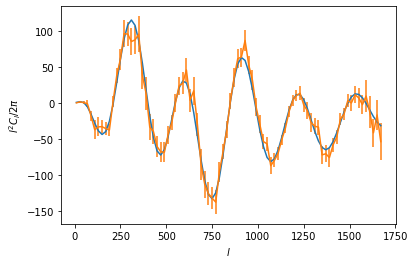

In [7]:
# binSpectrum()
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
ls, means, stds = binSpectrum(cmb.T_prim, cmb.E_prim, 20)

plt.plot(ls, cmb.C_TE(ls) *ls**2/(2*np.pi))
plt.errorbar(ls, means*ls**2/(2*np.pi), yerr=stds*ls**2/(2*np.pi))

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.show()
# validate: curves match and errorbars are reasonable

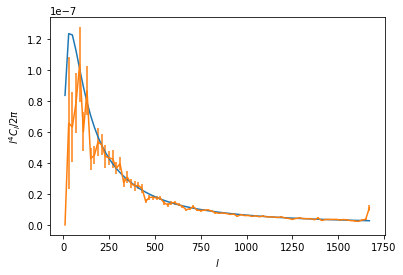

In [8]:
# binSpectrum() for phi phi
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
ls, means, stds = binSpectrum(cmb.p, cmb.p, 20)

plt.plot(ls, cmb.C_pp(ls) *ls**4/(2*np.pi))
plt.errorbar(ls, means*ls**4/(2*np.pi), yerr=stds*ls**4/(2*np.pi))

plt.xlabel('$l$')
plt.ylabel('$l^4 C_l / 2\pi$')
plt.show()
# validate: curves match and errorbars are reasonable

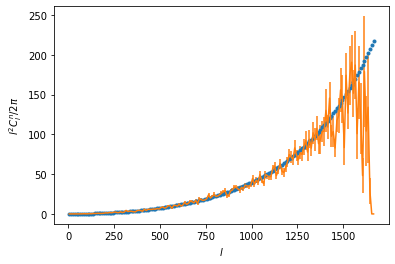

In [9]:
# setNoiseMaps and binSpectrum
cmb = CMBGenerator(powers, 0.4, 150)
cmb.setNoiseMaps(45, 45*np.sqrt(2), 5)
ls, means, stds = binSpectrum(cmb.T_noise, cmb.T_noise)

plt.plot(ls, cmb.C_TT_n(ls) *ls**2/(2*np.pi), '.')
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds * ls**2/(2*np.pi))

plt.xlabel('$l$')
plt.ylabel('$l^2 C^n_l / 2\pi$')
plt.show()
# validate: curves match and errorbars are reasonable

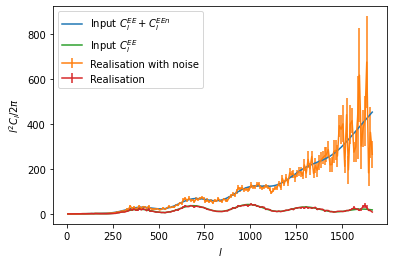

In [10]:
# primordial + noise map has power spectrum C_XX + C_XX_n
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(45, 45*np.sqrt(2), 5)
E_tot = cmb.E_prim + cmb.E_noise
ls, means, stds = binSpectrum(E_tot, E_tot)

# prim + noise
plt.plot(ls, (cmb.C_EE(ls)+cmb.C_EE_n(ls)) *ls**2/(2*np.pi), label='Input $C^{EE}_l + C^{EEn}_l$')
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds * ls**2/(2*np.pi), label='Realisation with noise')

ls, means, stds = binSpectrum(cmb.E_prim, cmb.E_prim)

# just prim
plt.plot(ls, cmb.C_EE(ls) *ls**2/(2*np.pi), label='Input $C^{EE}_l$')
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds * ls**2/(2*np.pi), label='Realisation')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.legend()
plt.show()
# validate: curves match and errorbars are reasonable

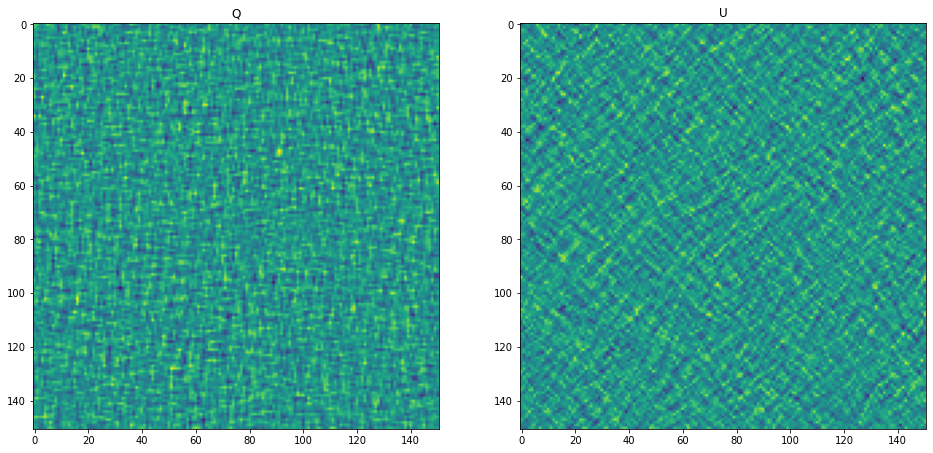

In [11]:
# EB to QU
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
Q_map, U_map = cmb.EB2QU(cmb.E_prim, cmb.B_prim)

plot2Maps(Q_map.real, U_map.real, r'Q', r'U')
# validate: Q has vertical/horizontal patterns, U has diagonal patterns

In [12]:
# QU to EB
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setNoiseMaps(45, 45*np.sqrt(2), 5)
Q_map, U_map = cmb.EB2QU(cmb.E_noise, cmb.B_noise)
E_map, B_map = cmb.QU2EB(Q_map, U_map)

# plot2Maps(cmb.E_noise.real, cmb.B_noise.real, r'E original', r'B original')
# plot2Maps(E_map.real, B_map.real, r'E', r'B')
# print biggest error after inversing divided by smallest original pixel
print(np.max(np.abs(E_map.real-cmb.E_noise.real))/np.min(np.abs(cmb.E_noise.real)))
print(np.max(np.abs(B_map.real-cmb.B_noise.real))/np.min(np.abs(cmb.B_noise.real)))
# validate: numbers (relative error after inversing) are super small

1.528439770506483e-10
9.902102074500432e-11


# Lensing and convolution

In [3]:
# deflection()
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()
d = cmb.deflection()
np.sqrt(np.mean([v[0]**2+v[1]**2 for v in np.concatenate(d)])) /np.pi*180*60
# validate: ~2 (arcmin)

1.5315152017986464

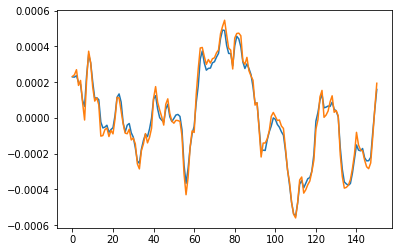

In [8]:
# deflection by FFT
cmb = CMBGenerator(powers, 0.4, 151)
cmb.setPrimordialMaps()

factor = cmb.N/cmb.W
d_real = np.gradient(cmb.p.real*factor) # gradient is taken in pixel coordinates, convert to radians
d_real_grad = np.zeros((cmb.N, cmb.N, 2))
d_real_grad[:,:,0] = d_real[0]
d_real_grad[:,:,1] = d_real[1]

d_fourier = tensorProd(cmb.p.fourier, 1j*cmb.ls_grid)
d_real = np.fft.irfft2(d_fourier, s=(cmb.N, cmb.N), axes=(0, 1))

plt.plot(d_real_grad[50,:,0])
plt.plot(d_real[50,:,0])
plt.show()
# validate: curves more or less match
# (they won't match exactly because difference quotient in discrete real space
# is not equal to multiplying by j*ell in discrete Fourier space)

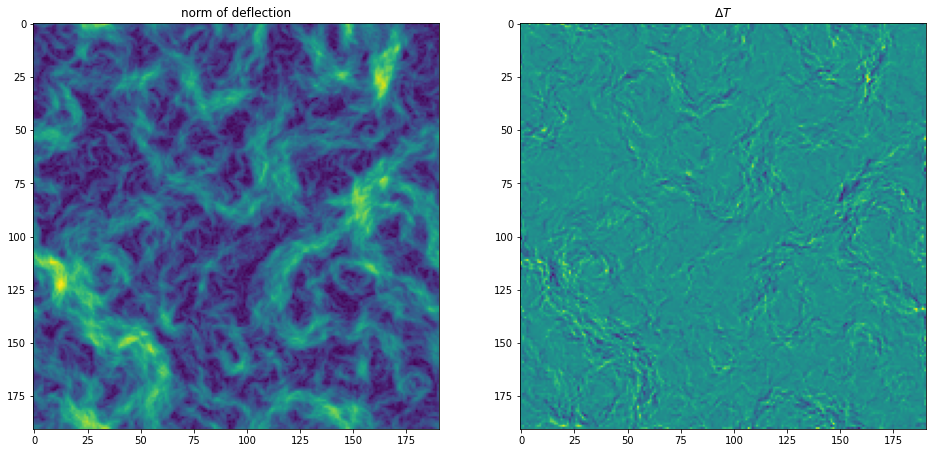

In [3]:
# lensMapInterp()
cmb = CMBGenerator(powers, 0.4, 191)
cmb.setPrimordialMaps()
d = cmb.deflection()
T_lensed = lensMapInterp(cmb.T_prim, d)
d_norm = np.zeros(d.shape[:2])
for i, j in np.ndindex(d_norm.shape):
    d_norm[i,j] = np.linalg.norm(d[i,j])

plot2Maps(d_norm, T_lensed.real-cmb.T_prim.real, 'norm of deflection', r'$\Delta T$')
# validate: locations of swirls more or less match up

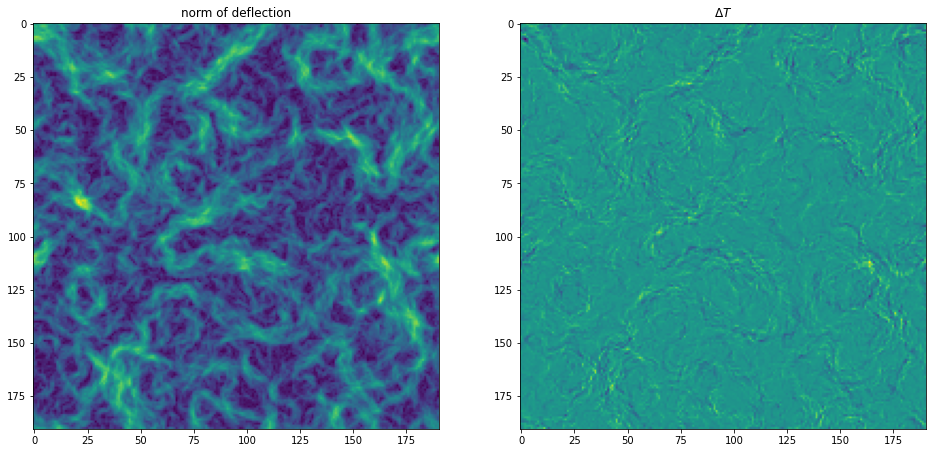

In [3]:
# lensMapTaylorNearest()
cmb = CMBGenerator(powers, 0.4, 191)
cmb.setPrimordialMaps()
d = cmb.deflection()
T_lensed = lensMapTaylorNearest(cmb.T_prim, d)
d_norm = np.zeros(d.shape[:2])
for i, j in np.ndindex(d_norm.shape):
    d_norm[i,j] = np.linalg.norm(d[i,j])

plot2Maps(d_norm, T_lensed.real-cmb.T_prim.real, 'norm of deflection', r'$\Delta T$')
# validate: locations of swirls more or less match up

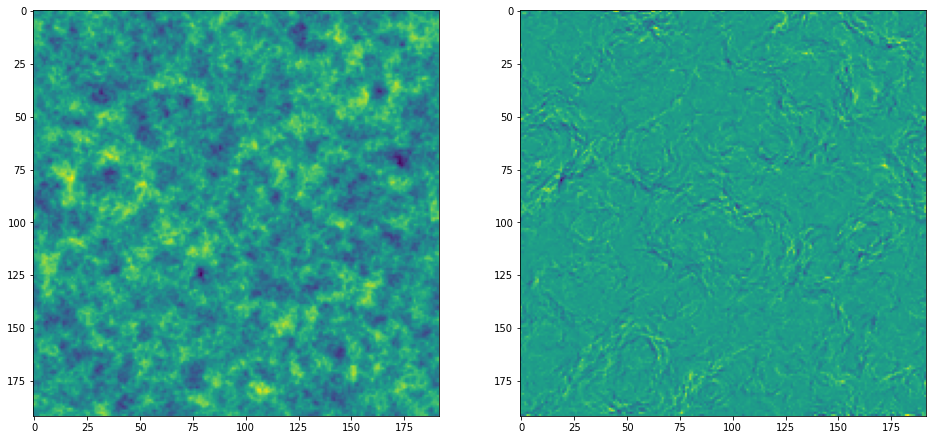

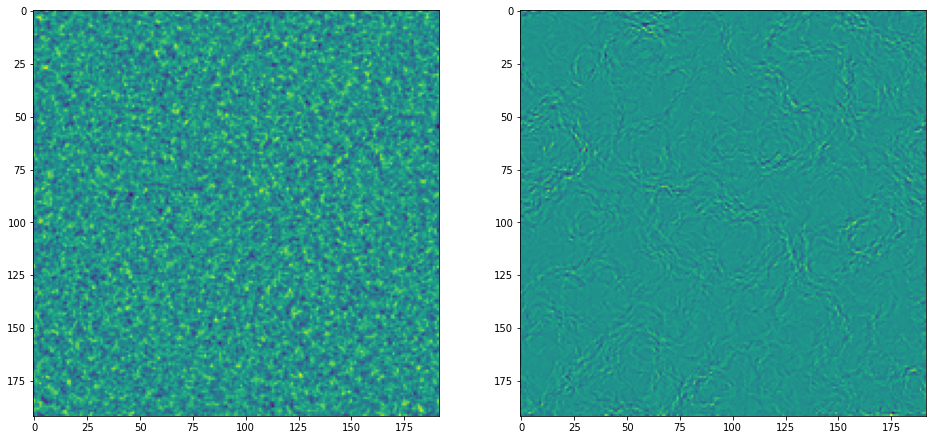

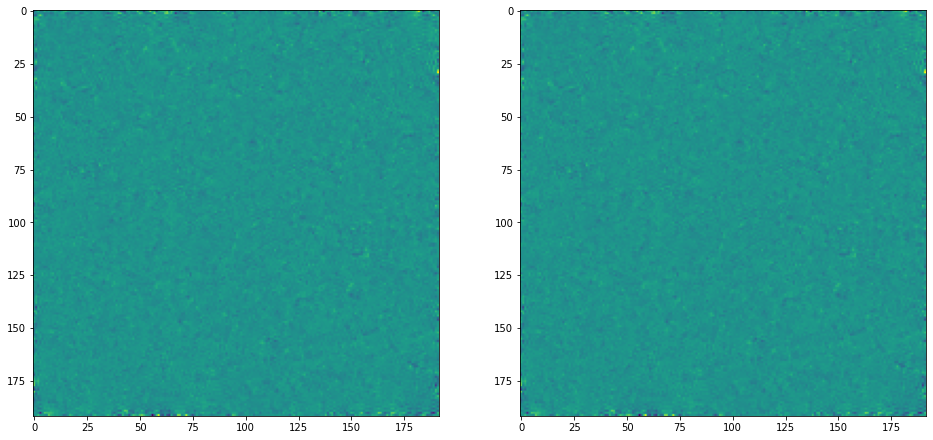

In [4]:
# setLensedMaps() using interp
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setLensedMaps(mode='interp')

plot2Maps(cmb.T_lensed.real, (cmb.T_lensed-cmb.T_prim).real)
plot2Maps(cmb.E_lensed.real, (cmb.E_lensed-cmb.E_prim).real)
plot2Maps(cmb.B_lensed.real, (cmb.B_lensed-cmb.B_prim).real)
# validate: swirls are kind of in the right places

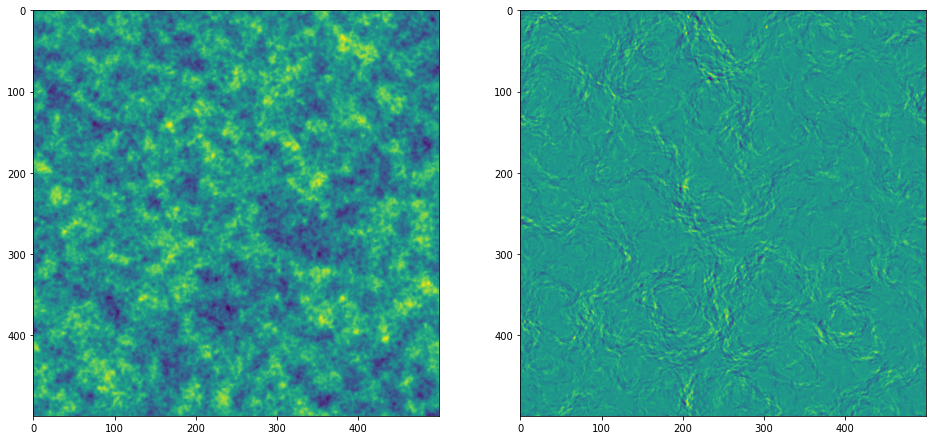

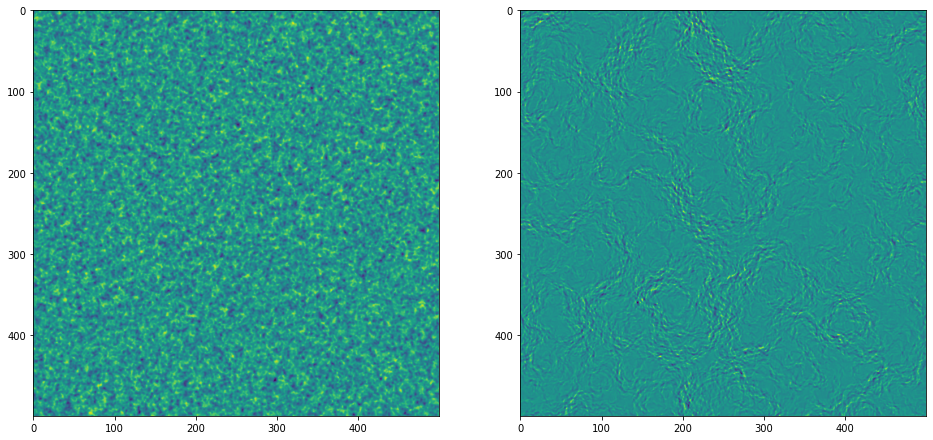

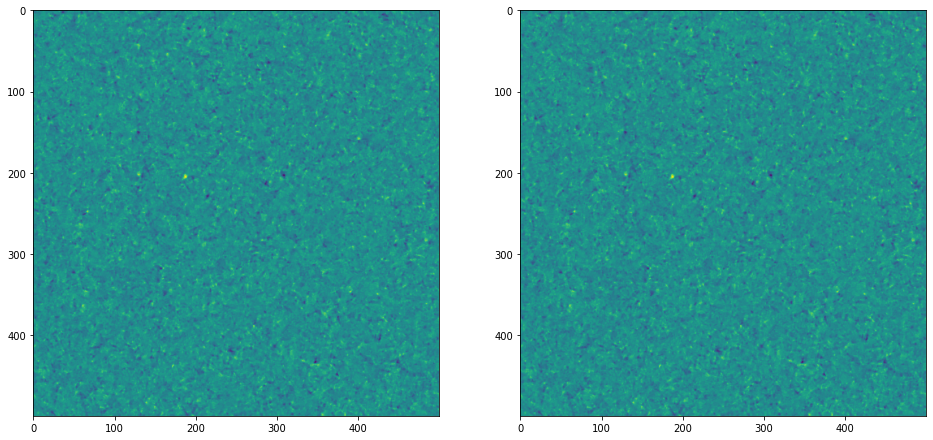

In [14]:
# setLensedMaps() using Taylor expansions around nearest grid point
cmb = CMBGenerator(powers, 0.4, 500)
cmb.setPrimordialMaps()
cmb.setLensedMaps(mode='nearest')

plot2Maps(cmb.T_lensed.real, (cmb.T_lensed-cmb.T_prim).real)
plot2Maps(cmb.E_lensed.real, (cmb.E_lensed-cmb.E_prim).real)
plot2Maps(cmb.B_lensed.real, (cmb.B_lensed-cmb.B_prim).real)
# validate: swirls are kind of in the right places
# !!! B mode seems to have a lot of artefact and is very different from interp above

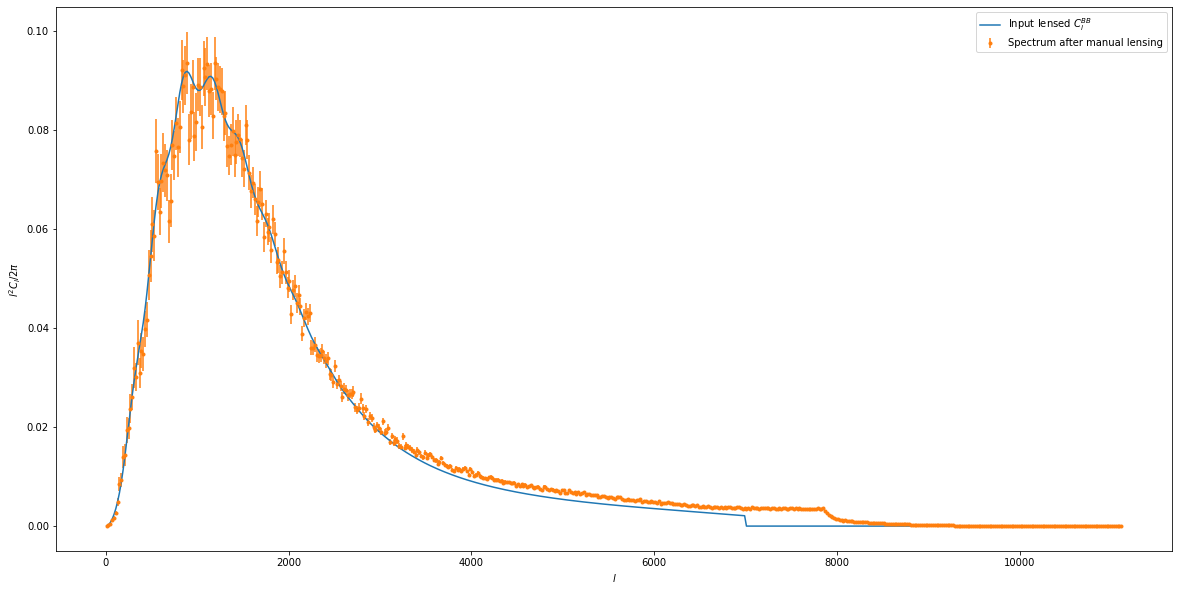

In [16]:
# lensed power spectrum (interp)
cmb = CMBGenerator(powers, 0.4, 1000)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*planck_params)
cmb.setLensedMaps(mode='interp')
ls = np.arange(powers['lensed_scalar'].shape[0])

plt.figure(figsize=(20,10))

ls, means, stds = binSpectrum(cmb.B_lensed, cmb.B_lensed, delta=20)
plt.plot(ls, cmb.C_BB_lensed(ls) *ls**2/(2*np.pi), label='Input lensed $C^{BB}_l$')
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds * ls**2/(2*np.pi), fmt='.', label='Spectrum after manual lensing')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.legend()
plt.show()
# validate: curves match
# needs high enough N (>1000) to reduce bias

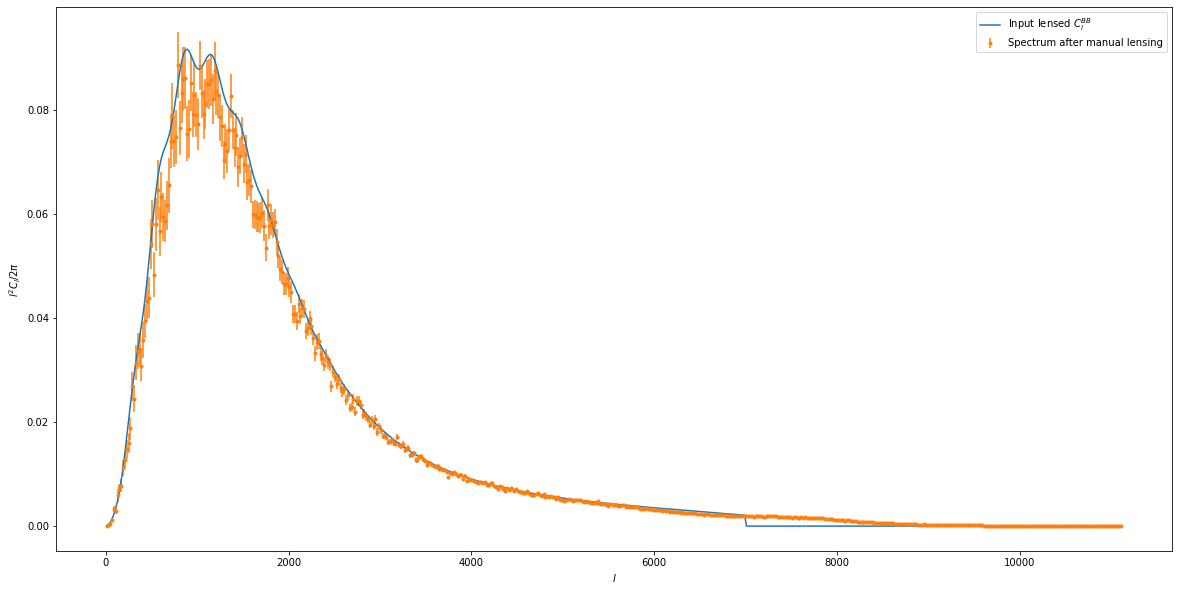

In [18]:
# lensed power spectrum (taylor)
cmb = CMBGenerator(powers, 0.4, 1000)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*planck_params)
cmb.setLensedMaps(mode='nearest')
ls = np.arange(powers['lensed_scalar'].shape[0])

plt.figure(figsize=(20,10))

ls, means, stds = binSpectrum(cmb.B_lensed, cmb.B_lensed, delta=20)
plt.plot(ls, cmb.C_BB_lensed(ls) *ls**2/(2*np.pi), label='Input lensed $C^{BB}_l$')
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds * ls**2/(2*np.pi), fmt='.', label='Spectrum after manual lensing')

plt.xlabel('$l$')
plt.ylabel('$l^2 C_l / 2\pi$')
plt.legend()
plt.show()
# validate: curves match
# needs high enough N (>1000) to reduce bias
# overall less power than interp, maybe even a deficiency

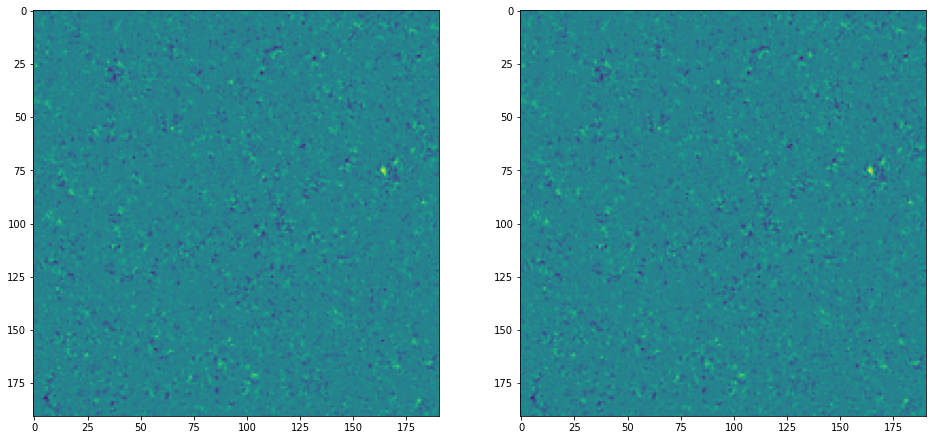

1.6094325937334876e-09

In [28]:
# convolveIntegral()
cmb = CMBGenerator(powers, 0.4, 191)
cmb.setPrimordialMaps()
conv1_fourier = cmb.convolveIntegral([(cmb.T_prim.fourier, cmb.E_prim.fourier)])
conv1 = np.fft.irfft2(conv1_fourier, s=(cmb.N, cmb.N))
conv2 = cmb.T_prim.real*cmb.E_prim.real

plot2Maps(conv1, conv2)
np.max(np.abs(conv1-conv2))/np.min(np.abs(conv2))
# validate: plots look similar, relative difference as a ratio is very small

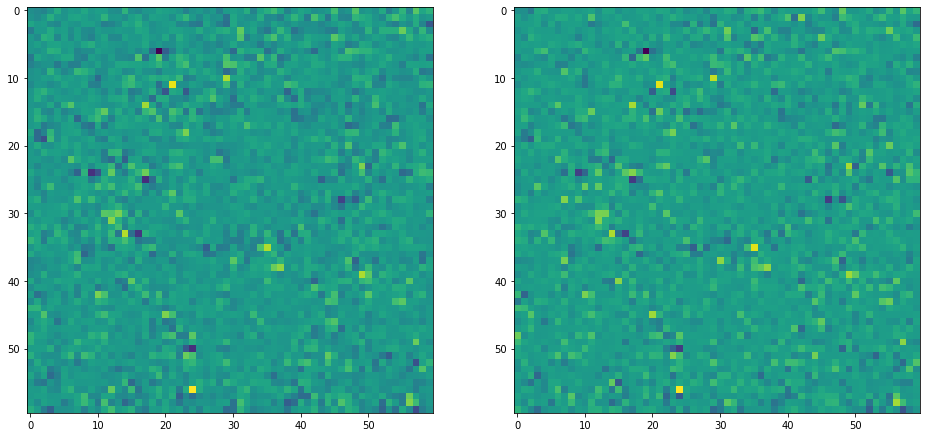

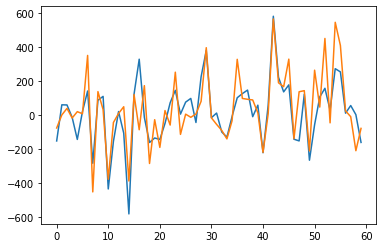

In [11]:
# convolution by fft actually matches convolution by direct sum
# just a proof of concept, not used in actual code
cmb = CMBGenerator(powers, 0.4, 60)
cmb.setPrimordialMaps()

fmap1 = np.fft.fftshift(mirrorFourier(cmb.T_prim.fourier))
fmap2 = np.fft.fftshift(mirrorFourier(cmb.E_prim.fourier))
conv = np.fft.ifftshift(convolve(fmap1, fmap2))[:,:cmb.N//2+1]
conv_fft = np.fft.rfft2(np.fft.irfft2(cmb.T_prim.fourier)*np.fft.irfft2(cmb.E_prim.fourier))

plot2Maps(np.fft.irfft2(conv), np.fft.irfft2(conv_fft))
plt.plot(np.fft.irfft2(conv)[41])
plt.plot(np.fft.irfft2(conv_fft)[41])
plt.show()
# validate: maps look similar, curves more or less overlap

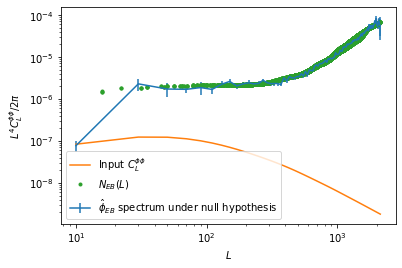

In [19]:
# phi_EB estimator under null hypothesis (Planck)
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*planck_params)
cmb.setLensedMaps()
p_est_EB = cmb.lensingEstimator(*cmb.lensing_EB(null=True))

integral = cmb.convolveIntegral(cmb.lensing_EB(null=True)[1])
integral[0,0] = np.inf
p_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# phi_EB estimator deflection power spectrum
ls, means, stds = binSpectrum(p_est_EB, p_est_EB, delta=20)
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds *ls**4/(2*np.pi), label=r'$\hat\phi_{EB}$ spectrum under null hypothesis')

# input deflection power spectrum
plt.loglog(ls, cmb.C_pp(ls) *ls**4/(2*np.pi), label=r'Input $C^{\phi\phi}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(p_est_EB_noise.fourier) *norm_ls**4/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_pp(L)

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: blue and green curves match, all curves match (order of magnitude) Fig. 3(a) of https://arxiv.org/pdf/astro-ph/0111606.pdf

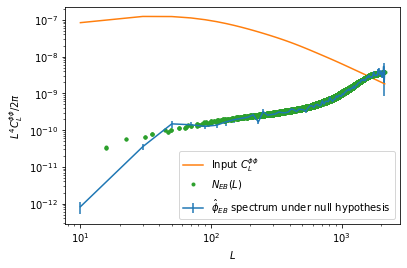

In [20]:
# phi_EB estimator under null hypothesis (CMB-S4)
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps()
p_est_EB = cmb.lensingEstimator(*cmb.lensing_EB(null=True))

integral = cmb.convolveIntegral(cmb.lensing_EB(null=True)[1])
integral[0,0] = np.inf
p_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# phi_EB estimator deflection power spectrum
ls, means, stds = binSpectrum(p_est_EB, p_est_EB, delta=20)
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds *ls**4/(2*np.pi), label=r'$\hat\phi_{EB}$ spectrum under null hypothesis')

# input deflection power spectrum
plt.loglog(ls, cmb.C_pp(ls) *ls**4/(2*np.pi), label=r'Input $C^{\phi\phi}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(p_est_EB_noise.fourier) *norm_ls**4/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_pp(L)

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: blue and green curves match, all curves match (order of magnitude) Fig. 3(b) of https://arxiv.org/pdf/astro-ph/0111606.pdf

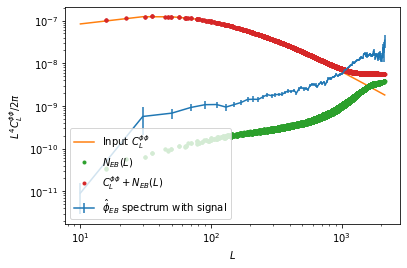

In [21]:
# phi_EB estimator (CMB-S4)
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps()
p_est_EB = cmb.lensingEstimator(*cmb.lensing_EB())

integral = cmb.convolveIntegral(cmb.lensing_EB()[1])
integral[0,0] = np.inf
p_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# phi_EB estimator deflection power spectrum
ls, means, stds = binSpectrum(p_est_EB, p_est_EB, delta=20)
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds *ls**4/(2*np.pi), label=r'$\hat\phi_{EB}$ spectrum with signal')

# input deflection power spectrum
plt.loglog(ls, cmb.C_pp(ls) *ls**4/(2*np.pi), label=r'Input $C^{\phi\phi}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(p_est_EB_noise.fourier) *norm_ls**4/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_pp(L)
plt.plot(norm_ls, (np.concatenate(p_est_EB_noise.fourier) * (cmb.N/cmb.W)**2 + cmb.C_pp(norm_ls)) *norm_ls**4/(2*np.pi) , '.', label=r'$C^{\phi\phi}_L+N_{EB}(L)$')

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: ??

# Rotation

In [22]:
ls_arr = np.concatenate((range(1, 31), range(31, 300, 10)))
# in rad**2
C_aa_term1_arr = np.array([2.29088627e-05, 1.48105445e-05, 9.08598523e-06, 5.58377020e-06, 3.52360808e-06, 2.36849437e-06, 1.73989384e-06, 1.39443959e-06, 1.18716510e-06, 1.04568866e-06, 9.31635980e-07, 8.24376733e-07, 7.19231210e-07, 6.20790596e-07, 5.34038560e-07, 4.62891919e-07, 4.07691501e-07, 3.66194017e-07, 3.34662797e-07, 3.08316250e-07, 2.84163602e-07, 2.61800086e-07, 2.41591752e-07, 2.23177145e-07, 2.05363067e-07, 1.88203718e-07, 1.72409669e-07, 1.59008270e-07, 1.47886254e-07, 1.38550589e-07, 1.29995571e-07, 7.19999394e-08, 4.48694280e-08, 3.00271228e-08, 2.07889832e-08, 1.48063413e-08, 1.10984425e-08, 8.45953864e-09, 6.46847069e-09, 5.02016468e-09, 3.88234810e-09, 3.13574559e-09, 2.55212854e-09, 2.08499464e-09, 1.69280825e-09, 1.39821062e-09, 1.21059653e-09, 1.02715603e-09, 8.61965643e-10, 7.16159117e-10, 5.78201939e-10, 5.21854231e-10, 4.15333953e-10, 4.10262986e-10, 3.06035680e-10, 3.30981276e-10, 2.49152719e-10])
C_aa_term2_arr = np.array([9.46058606e-06, 6.28307136e-06, 3.96798908e-06, 2.50569628e-06, 1.62131644e-06, 1.11045126e-06, 8.23868424e-07, 6.63831020e-07, 5.68697261e-07, 5.02813575e-07, 4.48030324e-07, 3.96788444e-07, 3.47941502e-07, 3.03077803e-07, 2.64076229e-07, 2.31948146e-07, 2.06295658e-07, 1.86119782e-07, 1.70112329e-07, 1.56965303e-07, 1.45431720e-07, 1.34793287e-07, 1.24760561e-07, 1.15232952e-07, 1.06318995e-07, 9.81557247e-08, 9.08911416e-08, 8.46169038e-08, 7.91871478e-08, 7.44921618e-08, 7.02978756e-08, 4.09313993e-08, 2.61857450e-08, 1.80181712e-08, 1.30274886e-08, 9.65402402e-09, 7.37225609e-09, 5.74554143e-09, 4.57121864e-09, 3.68979424e-09, 3.00720659e-09, 2.48514661e-09, 2.07055555e-09, 1.74095332e-09, 1.47887955e-09, 1.25523626e-09, 1.07298167e-09, 9.27491270e-10, 8.06925580e-10, 7.13345526e-10, 5.89726348e-10, 5.53498647e-10, 4.70866811e-10, 4.29590493e-10, 3.72846310e-10, 3.36639600e-10, 2.95217794e-10])
C_aa_term1 = sp.interpolate.interp1d(ls_arr, C_aa_term1_arr, kind='cubic', bounds_error=False, fill_value=0)
C_aa_term2 = sp.interpolate.interp1d(ls_arr, C_aa_term2_arr, kind='cubic', bounds_error=False, fill_value=0)
def C_aa(f_sub):
    def F(l):
        return (1-f_sub)*C_aa_term1(l) + f_sub*C_aa_term2(l)
    return F

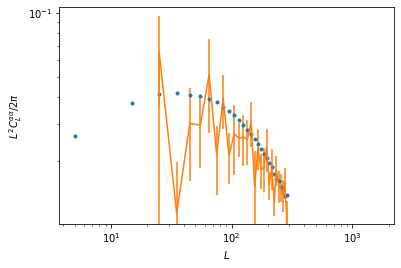

In [24]:
# setRotationMap()
cmb = CMBGenerator(powers, 0.4, 150)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*planck_params)
cmb.setLensedMaps()
cmb.setRotationMap(C_aa(0.8))

ls, means, stds = binSpectrum(cmb.a, cmb.a)

# convert to deg**2
plt.loglog(ls, C_aa(0.8)(ls) *ls**2/(2*np.pi) * (180/np.pi)**2, '.')
plt.errorbar(ls, means *ls**2/(2*np.pi) * (180/np.pi)**2, yerr=stds * ls**2/(2*np.pi) * (180/np.pi)**2)

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$')
plt.show()
# validate: curves match and errorbars are reasonable, match Fig. 7b of https://iopscience.iop.org/article/10.1088/1475-7516/2021/05/055/pdf

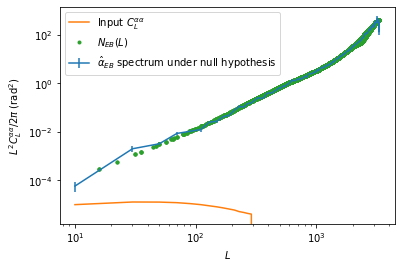

In [25]:
# a_EB estimator under null hypothesis (Planck)
f_sub = 0.8
cmb = CMBGenerator(powers, 0.4, 300)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*planck_params)
cmb.setLensedMaps()
cmb.setRotationMap(C_aa(f_sub))
cmb.setRotatedMaps()
a_est_EB = cmb.rotationEstimator(*cmb.rotation_EB(null=True))

integral = cmb.convolveIntegral(cmb.rotation_EB(null=True)[1])
integral[0,0] = np.inf
a_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# alpha_EB estimator power spectrum
ls, means, stds = binSpectrum(a_est_EB, a_est_EB, delta=20)
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds *ls**2/(2*np.pi), label=r'$\hat\alpha_{EB}$ spectrum under null hypothesis')

# input rotation power spectrum
plt.loglog(ls, C_aa(f_sub)(ls) *ls**2/(2*np.pi), label=r'Input $C^{\alpha\alpha}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_aa(L)

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ ($\mathrm{rad}^2$)')
plt.legend()
plt.show()
# validate: blue and green curves match
# (???) They match for planck and simons but not cmb_s4

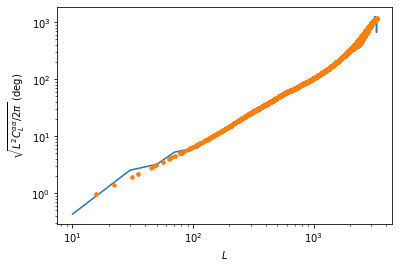

In [26]:
# above but sqrt and in deg
plt.loglog(ls, np.sqrt(means*ls**2/(2*np.pi) * (180/np.pi)**2))
plt.loglog(norm_ls, (180/np.pi) * np.sqrt(np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2), '.')

plt.xlabel('$L$')
plt.ylabel(r'$\sqrt{L^2 C^{\alpha\alpha}_L / 2\pi}$ (deg)')
plt.show()
# validate: both match Fig. 1 of https://arxiv.org/pdf/2111.12741.pdf

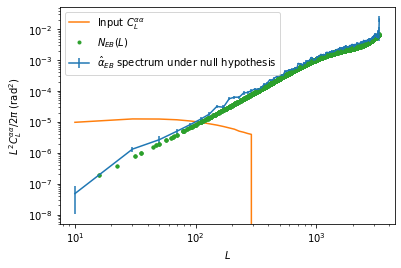

In [27]:
# a_EB estimator under null hypothesis (CMB-S4)
f_sub = 0.8
cmb = CMBGenerator(powers, 0.4, 300)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps()
cmb.setRotationMap(C_aa(f_sub))
cmb.setRotatedMaps()
a_est_EB = cmb.rotationEstimator(*cmb.rotation_EB(null=True))

integral = cmb.convolveIntegral(cmb.rotation_EB(null=True)[1])
integral[0,0] = np.inf
a_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# alpha_EB estimator power spectrum
ls, means, stds = binSpectrum(a_est_EB, a_est_EB, delta=20)
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds *ls**2/(2*np.pi), label=r'$\hat\alpha_{EB}$ spectrum under null hypothesis')

# input rotation power spectrum
plt.loglog(ls, C_aa(f_sub)(ls) *ls**2/(2*np.pi), label=r'Input $C^{\alpha\alpha}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_aa(L)

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ ($\mathrm{rad}^2$)')
plt.legend()
plt.show()
# validate: blue and green curves match
# ??? deviation, due to deviation of lensing spectrum above?
# no deviation when using lensed=False

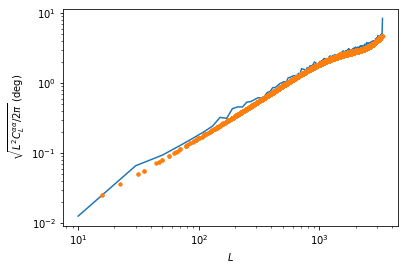

In [28]:
# above but sqrt and in deg
plt.loglog(ls, np.sqrt(means*ls**2/(2*np.pi) * (180/np.pi)**2))
plt.loglog(norm_ls, (180/np.pi) * np.sqrt(np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2), '.')

plt.xlabel('$L$')
plt.ylabel(r'$\sqrt{L^2 C^{\alpha\alpha}_L / 2\pi}$ (deg)')
plt.show()
# validate: both match Fig. 1 of https://arxiv.org/pdf/2111.12741.pdf

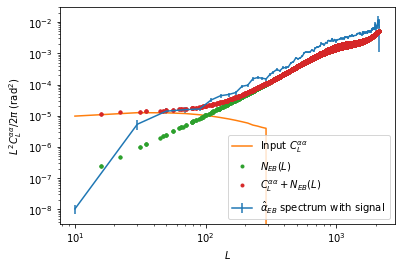

In [29]:
# a_EB estimator (CMB-S4)
f_sub = 0.8
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps()
cmb.setRotationMap(C_aa(f_sub))
cmb.setRotatedMaps()
a_est_EB = cmb.rotationEstimator(*cmb.rotation_EB())

integral = cmb.convolveIntegral(cmb.rotation_EB()[1])
integral[0,0] = np.inf
a_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# alpha_EB estimator power spectrum
ls, means, stds = binSpectrum(a_est_EB, a_est_EB, delta=20)
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds *ls**2/(2*np.pi), label=r'$\hat\alpha_{EB}$ spectrum with signal')

# input rotation power spectrum
plt.loglog(ls, C_aa(f_sub)(ls) *ls**2/(2*np.pi), label=r'Input $C^{\alpha\alpha}_L$')

# alpha_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_aa(L)
plt.plot(norm_ls, (np.concatenate(a_est_EB_noise.fourier) * (cmb.N/cmb.W)**2 + C_aa(f_sub)(norm_ls)) *norm_ls**2/(2*np.pi) , '.', label=r'$C^{\alpha\alpha}_L+N_{EB}(L)$')

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ ($\mathrm{rad}^2$)')
plt.legend()
plt.show()
# validate: ??

# Testing

In [4]:
from rotation_reconstruction import *

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.4, ombh2=0.0224, omch2=0.12, mnu=0.06, omk=0, tau=0.054)
pars.InitPower.set_params(As=2e-9, ns=0.965, r=0)
pars.set_for_lmax(7000, lens_potential_accuracy=2) # lens_potential_accuracy=1 is Planck accuracy. See doc
results = camb.get_results(pars)
# get dictionary of CAMB power spectra, 'unlensed_scalar' is ordered TT, EE, BB, TE, with BB = 0
# 'lens_potential' is orderd psi_psi, T_psi, E_psi
powers = results.get_cmb_power_spectra(pars, CMB_unit='muK', raw_cl=True) # raw_cl so that no factors of ell are multiplied to C_ell
# for name in powers: print(name)

cmb = CMBGenerator(powers, 0.23, 1560)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps(mode='nearest')

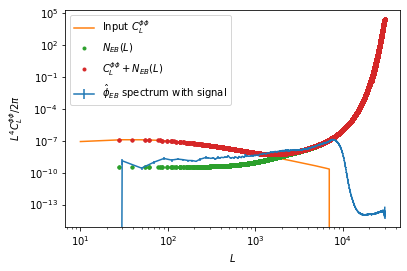

In [2]:
# phi_EB estimator (CMB-S4)

p_est_EB = cmb.lensingEstimator(*cmb.lensing_EB())

integral = cmb.convolveIntegral(cmb.lensing_EB()[1])
integral[0,0] = np.inf
p_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# phi_EB estimator deflection power spectrum
ls, means, stds = binSpectrum(p_est_EB, p_est_EB, delta=20)
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds *ls**4/(2*np.pi), label=r'$\hat\phi_{EB}$ spectrum with signal')

# input deflection power spectrum
plt.loglog(ls, cmb.C_pp(ls) *ls**4/(2*np.pi), label=r'Input $C^{\phi\phi}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(p_est_EB_noise.fourier) *norm_ls**4/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_pp(L)
plt.plot(norm_ls, (np.concatenate(p_est_EB_noise.fourier) * (cmb.N/cmb.W)**2 + cmb.C_pp(norm_ls)) *norm_ls**4/(2*np.pi) , '.', label=r'$C^{\phi\phi}_L+N_{EB}(L)$')

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: ??

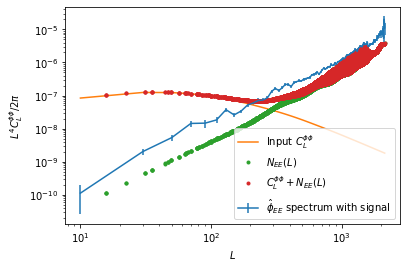

In [32]:
# phi_EE estimator (CMB-S4)
cmb = CMBGenerator(powers, 0.4, 192)
cmb.setPrimordialMaps()
cmb.setNoiseMaps(*cmb_s4_params)
cmb.setLensedMaps()
p_est_EE = cmb.lensingEstimator(*cmb.lensing_EE())

integral = cmb.convolveIntegral(cmb.lensing_EE()[1])
integral[0,0] = np.inf
p_est_EE_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# phi_EB estimator deflection power spectrum
ls, means, stds = binSpectrum(p_est_EE, p_est_EE, delta=20)
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds *ls**4/(2*np.pi), label=r'$\hat\phi_{EE}$ spectrum with signal')

# input deflection power spectrum
plt.loglog(ls, cmb.C_pp(ls) *ls**4/(2*np.pi), label=r'Input $C^{\phi\phi}_L$')

# phi_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(p_est_EE_noise.fourier) *norm_ls**4/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EE}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_pp(L)
plt.plot(norm_ls, (np.concatenate(p_est_EE_noise.fourier) * (cmb.N/cmb.W)**2 + cmb.C_pp(norm_ls)) *norm_ls**4/(2*np.pi) , '.', label=r'$C^{\phi\phi}_L+N_{EE}(L)$')

plt.xlabel('$L$')
plt.ylabel('$L^4 C^{\phi\phi}_L / 2\pi$')
plt.legend()
plt.show()
# validate: ??

In [6]:
ls_arr = np.concatenate((range(1, 31), range(31, 300, 10)))
# in rad**2
C_aa_term1_arr = np.array([2.29088627e-05, 1.48105445e-05, 9.08598523e-06, 5.58377020e-06, 3.52360808e-06, 2.36849437e-06, 1.73989384e-06, 1.39443959e-06, 1.18716510e-06, 1.04568866e-06, 9.31635980e-07, 8.24376733e-07, 7.19231210e-07, 6.20790596e-07, 5.34038560e-07, 4.62891919e-07, 4.07691501e-07, 3.66194017e-07, 3.34662797e-07, 3.08316250e-07, 2.84163602e-07, 2.61800086e-07, 2.41591752e-07, 2.23177145e-07, 2.05363067e-07, 1.88203718e-07, 1.72409669e-07, 1.59008270e-07, 1.47886254e-07, 1.38550589e-07, 1.29995571e-07, 7.19999394e-08, 4.48694280e-08, 3.00271228e-08, 2.07889832e-08, 1.48063413e-08, 1.10984425e-08, 8.45953864e-09, 6.46847069e-09, 5.02016468e-09, 3.88234810e-09, 3.13574559e-09, 2.55212854e-09, 2.08499464e-09, 1.69280825e-09, 1.39821062e-09, 1.21059653e-09, 1.02715603e-09, 8.61965643e-10, 7.16159117e-10, 5.78201939e-10, 5.21854231e-10, 4.15333953e-10, 4.10262986e-10, 3.06035680e-10, 3.30981276e-10, 2.49152719e-10])
C_aa_term2_arr = np.array([9.46058606e-06, 6.28307136e-06, 3.96798908e-06, 2.50569628e-06, 1.62131644e-06, 1.11045126e-06, 8.23868424e-07, 6.63831020e-07, 5.68697261e-07, 5.02813575e-07, 4.48030324e-07, 3.96788444e-07, 3.47941502e-07, 3.03077803e-07, 2.64076229e-07, 2.31948146e-07, 2.06295658e-07, 1.86119782e-07, 1.70112329e-07, 1.56965303e-07, 1.45431720e-07, 1.34793287e-07, 1.24760561e-07, 1.15232952e-07, 1.06318995e-07, 9.81557247e-08, 9.08911416e-08, 8.46169038e-08, 7.91871478e-08, 7.44921618e-08, 7.02978756e-08, 4.09313993e-08, 2.61857450e-08, 1.80181712e-08, 1.30274886e-08, 9.65402402e-09, 7.37225609e-09, 5.74554143e-09, 4.57121864e-09, 3.68979424e-09, 3.00720659e-09, 2.48514661e-09, 2.07055555e-09, 1.74095332e-09, 1.47887955e-09, 1.25523626e-09, 1.07298167e-09, 9.27491270e-10, 8.06925580e-10, 7.13345526e-10, 5.89726348e-10, 5.53498647e-10, 4.70866811e-10, 4.29590493e-10, 3.72846310e-10, 3.36639600e-10, 2.95217794e-10])
C_aa_term1 = sp.interpolate.interp1d(ls_arr, C_aa_term1_arr, kind='cubic', bounds_error=False, fill_value=0)
C_aa_term2 = sp.interpolate.interp1d(ls_arr, C_aa_term2_arr, kind='cubic', bounds_error=False, fill_value=0)
def C_aa(f_sub):
    def F(l):
        return ((1-f_sub)*C_aa_term1(l/10) + f_sub*C_aa_term2(l/10))*10*np.heaviside(l-200, 0)
    return F

cmb.setRotationMap(C_aa(f_sub))
cmb.setRotatedMaps()

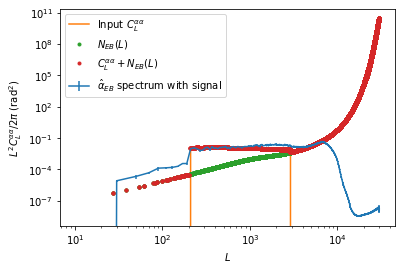

In [7]:
# a_EB estimator (CMB-S4)
f_sub = 0.8
a_est_EB = cmb.rotationEstimator(*cmb.rotation_EB())

integral = cmb.convolveIntegral(cmb.rotation_EB()[1])
integral[0,0] = np.inf
a_est_EB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# alpha_EB estimator power spectrum
ls, means, stds = binSpectrum(a_est_EB, a_est_EB, delta=20)
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds *ls**2/(2*np.pi), label=r'$\hat\alpha_{EB}$ spectrum with signal')

# input rotation power spectrum
plt.loglog(ls, C_aa(f_sub)(ls) *ls**2/(2*np.pi), label=r'Input $C^{\alpha\alpha}_L$')

# alpha_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(a_est_EB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{EB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_aa(L)
plt.plot(norm_ls, (np.concatenate(a_est_EB_noise.fourier) * (cmb.N/cmb.W)**2 + C_aa(f_sub)(norm_ls)) *norm_ls**2/(2*np.pi) , '.', label=r'$C^{\alpha\alpha}_L+N_{EB}(L)$')

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ ($\mathrm{rad}^2$)')
plt.legend()
plt.show()
# validate: ??

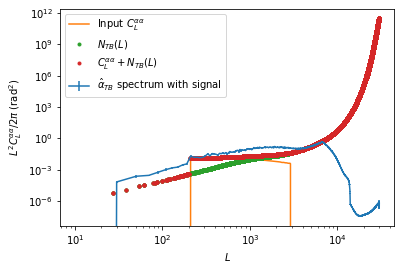

In [8]:
# a_TB estimator (CMB-S4)
f_sub = 0.8
a_est_TB = cmb.rotationEstimator(*cmb.rotation_TB())

integral = cmb.convolveIntegral(cmb.rotation_TB()[1])
integral[0,0] = np.inf
a_est_TB_noise = CMBMap(cmb.W, cmb.N, fourier_map=1/np.real(integral))

# alpha_EB estimator power spectrum
ls, means, stds = binSpectrum(a_est_TB, a_est_TB, delta=20)
plt.errorbar(ls, means *ls**2/(2*np.pi), yerr=stds *ls**2/(2*np.pi), label=r'$\hat\alpha_{TB}$ spectrum with signal')

# input rotation power spectrum
plt.loglog(ls, C_aa(f_sub)(ls) *ls**2/(2*np.pi), label=r'Input $C^{\alpha\alpha}_L$')

# alpha_EB estimator noise forecast
norm_ls = np.concatenate(cmb.norm_ls_grid)
plt.plot(norm_ls, np.concatenate(a_est_TB_noise.fourier) *norm_ls**2/(2*np.pi) * (cmb.N/cmb.W)**2, '.', label=r'$N_{TB}(L)$') # need (N/W)**2 factor to convert back to continuous N(L) to match C_aa(L)
plt.plot(norm_ls, (np.concatenate(a_est_TB_noise.fourier) * (cmb.N/cmb.W)**2 + C_aa(f_sub)(norm_ls)) *norm_ls**2/(2*np.pi) , '.', label=r'$C^{\alpha\alpha}_L+N_{TB}(L)$')

plt.xlabel('$L$')
plt.ylabel(r'$L^2 C^{\alpha\alpha}_L / 2\pi$ ($\mathrm{rad}^2$)')
plt.legend()
plt.show()
# validate: ??

<ErrorbarContainer object of 3 artists>

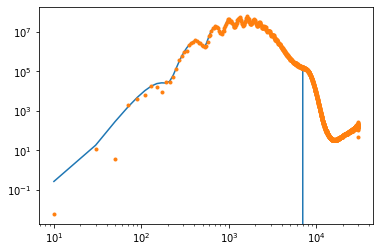

In [13]:
ls, means, stds = binSpectrum(cmb.E_lensed, cmb.E_lensed, delta=20)
plt.loglog(ls, cmb.C_EE_lensed(ls) *ls**4/(2*np.pi), label='Input lensed $C^{EE}_l$')
plt.errorbar(ls, means *ls**4/(2*np.pi), yerr=stds * ls**2/(2*np.pi), fmt='.', label='Spectrum after manual lensing')